<a href="https://colab.research.google.com/github/rismaamaliyah/tugas-akhir/blob/main/Real_Fixed_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Data**

In [ ]:
pip install tensorflow

In [ ]:
pip install nltk

In [ ]:
pip install gensim

In [ ]:
import pandas as pd
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
from tkinter.constants import Y
from imblearn.over_sampling import RandomOverSampler
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import gensim
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D, Embedding, Dropout
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from itertools import product
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = 'https://raw.githubusercontent.com/rismaamaliyah/tugas-akhir/main/dataset%20fixed.csv'
df = pd.read_csv(data)
df.drop(['Date'],axis=1,inplace=True)

# **Oversampling**

In [ ]:
df['Sentiment'].value_counts()

0    3839
1    1166
Name: Sentiment, dtype: int64

In [ ]:
X = df[['Tweet']]
Y = df['Sentiment']
ros = RandomOverSampler(random_state=1)
X_new, Y_new = ros.fit_resample(X,Y)
df= X_new
df['Sentiment'] = Y_new

In [ ]:
df['Sentiment'].value_counts()

0    3839
1    3839
Name: Sentiment, dtype: int64

# **Pre-processing**

In [ ]:
stemmer = PorterStemmer()

cleaned_tweets = []
for index, row in df.iterrows():
    tweet = row['Tweet']

    # Case folding
    tweet = tweet.casefold()

    # Cleaning data
    # Hapus tanda @
    tweet = re.sub(r'@[\w]*', '', tweet)
    # Hapus karakter non-alphanumerik
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # Hapus karakter selain huruf, angka, dan spasi dari teks tweet
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    # Hapus URL
    tweet = re.sub(r'http\S+|www\S+|ftp\S+', '', tweet)
    # Hapus emoji
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)

    # Tokenization
    tokens = word_tokenize(tweet)

    # Stopwords removal
    stop_words = set(stopwords.words('indonesian'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    cleaned_tweets.append(stemmed_tokens)

df['Cleaned Tweet'] = cleaned_tweets

In [ ]:
df.head(5)

,Tweet,Sentiment,Cleaned Tweet
0,Rekrutmen berdasarkan identitas bukan kualitas...,0,"[rekrutmen, berdasarkan, identita, kualita, me..."
1,BSI (BRIS) terancam sanksi UU Perlindungan Dat...,0,"[bsi, bri, terancam, sanksi, uu, perlindungan,..."
2,@bankbsi_id Alhamdulillah rekening saya sudah ...,1,"[alhamdulillah, reken, aman, saldo, pindahkan,..."
3,@bankbsi_id gila sampe hari ini pun tetep begi...,0,"[gila, samp, tetep, nih, top, up, aja, sulit, ..."
4,@sayit_uwu @joodieth @F2aldi @bankbsi_id Balik...,1,"[bsi, transaksi, gagal, 12, jam, kak, langsung..."


# **Split Data**

In [ ]:
y = df['Sentiment']

df_train, df_test, y_train, y_test = train_test_split(df['Cleaned Tweet'], y, test_size=0.1, random_state=42)
print('DF Train Shape: ', df_train.shape)
print('DF Test Shape: ', df_test.shape)
print('Y Train Shape: ', y_train.shape)
print('Y Test Shape: ', y_test.shape)

DF Train Shape:  (6910,)
DF Test Shape:  (768,)
Y Train Shape:  (6910,)
Y Test Shape:  (768,)


# **Word Embedding**

In [ ]:
max_words = 10000
tokenizer = Tokenizer(max_words)
tokenizer.fit_on_texts(df_train)
sequence_train = tokenizer.texts_to_sequences(df_train)
sequence_test = tokenizer.texts_to_sequences(df_test)

In [ ]:
model = gensim.models.Word2Vec(sequence_train, vector_size=300, window=5, min_count=1, workers=4)
word2vec = model.wv.index_to_key
V = len(word2vec)
print('dataset has %s number of independent tokens' %V)

dataset has 8665 number of independent tokens


In [ ]:
word_vectors = model.wv
embeddings_matrix = np.zeros((V + 1, model.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embeddings_matrix[i] = word_vectors[word]
print(embeddings_matrix.shape)

(8666, 300)


In [ ]:
data_train = pad_sequences(sequence_train)
print(data_train.shape)

T = data_train.shape[1]
data_test = pad_sequences(sequence_test,maxlen=T)
print(data_test.shape)

(6910, 109)
(768, 109)


# **Create CNN Model**

In [ ]:
def create_cnn_model(embedding_size=50, filters=[32, 64, 128], kernel_size=3):
    i = Input((T,))
    x = Embedding(V + 1, embedding_size)(i)
    x = Conv1D(filters[0], kernel_size, activation='relu', kernel_regularizer=l1(0.0001))(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(filters[1], kernel_size, activation='relu', kernel_regularizer=l1(0.0001))(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(filters[2], kernel_size, activation='relu', kernel_regularizer=l1(0.0001))(x)
    x = Dropout(0.5)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(20, activation='softmax')(x)
    model = Model(i, x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# **Optimizing Parameters**

In [ ]:
# Data untuk learning curves
train_accuracy_history = []
val_accuracy_history = []

embedding_sizes = [100, 200, 300]
kernel_sizes = [3, 5, 7]
filters_combinations = [(32, 64, 128), (64, 128, 256)]

best_accuracy = 0
best_params = {}

for embedding_size, filters, kernel_size in product(embedding_sizes, filters_combinations, kernel_sizes):
    model = create_cnn_model(embedding_size=embedding_size, filters=filters, kernel_size=kernel_size)
    history = model.fit(data_train, y_train, epochs=10, batch_size=100, validation_data=(data_test, y_test), verbose=0)

    # Simpan learning curves
    train_accuracy_history.append(history.history['accuracy'])
    val_accuracy_history.append(history.history['val_accuracy'])

    y_pred = model.predict(data_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred_classes)

    print("Parameters: embedding_size=%d, filters=%s, kernel_size=%d, Accuracy: %.2f%%" % (embedding_size, str(filters), kernel_size, accuracy))

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'embedding_size': embedding_size, 'filters': filters, 'kernel_size': kernel_size}

print("Best Accuracy: %f using %s" % (best_accuracy, best_params))

24/24 [==============================] - 0s 5ms/step
Parameters: embedding_size=100, filters=(32, 64, 128), kernel_size=3, Accuracy: 0.916667
24/24 [==============================] - 0s 5ms/step
Parameters: embedding_size=100, filters=(32, 64, 128), kernel_size=5, Accuracy: 0.873698
24/24 [==============================] - 0s 6ms/step
Parameters: embedding_size=100, filters=(32, 64, 128), kernel_size=7, Accuracy: 0.851562
24/24 [==============================] - 0s 8ms/step
Parameters: embedding_size=100, filters=(64, 128, 256), kernel_size=3, Accuracy: 0.907552
24/24 [==============================] - 0s 9ms/step
Parameters: embedding_size=100, filters=(64, 128, 256), kernel_size=5, Accuracy: 0.881510
24/24 [==============================] - 1s 18ms/step
Parameters: embedding_size=100, filters=(64, 128, 256), kernel_size=7, Accuracy: 0.843750
24/24 [==============================] - 0s 6ms/step
Parameters: embedding_size=200, filters=(32, 64, 128), kernel_size=3, Accuracy: 0.917969
24

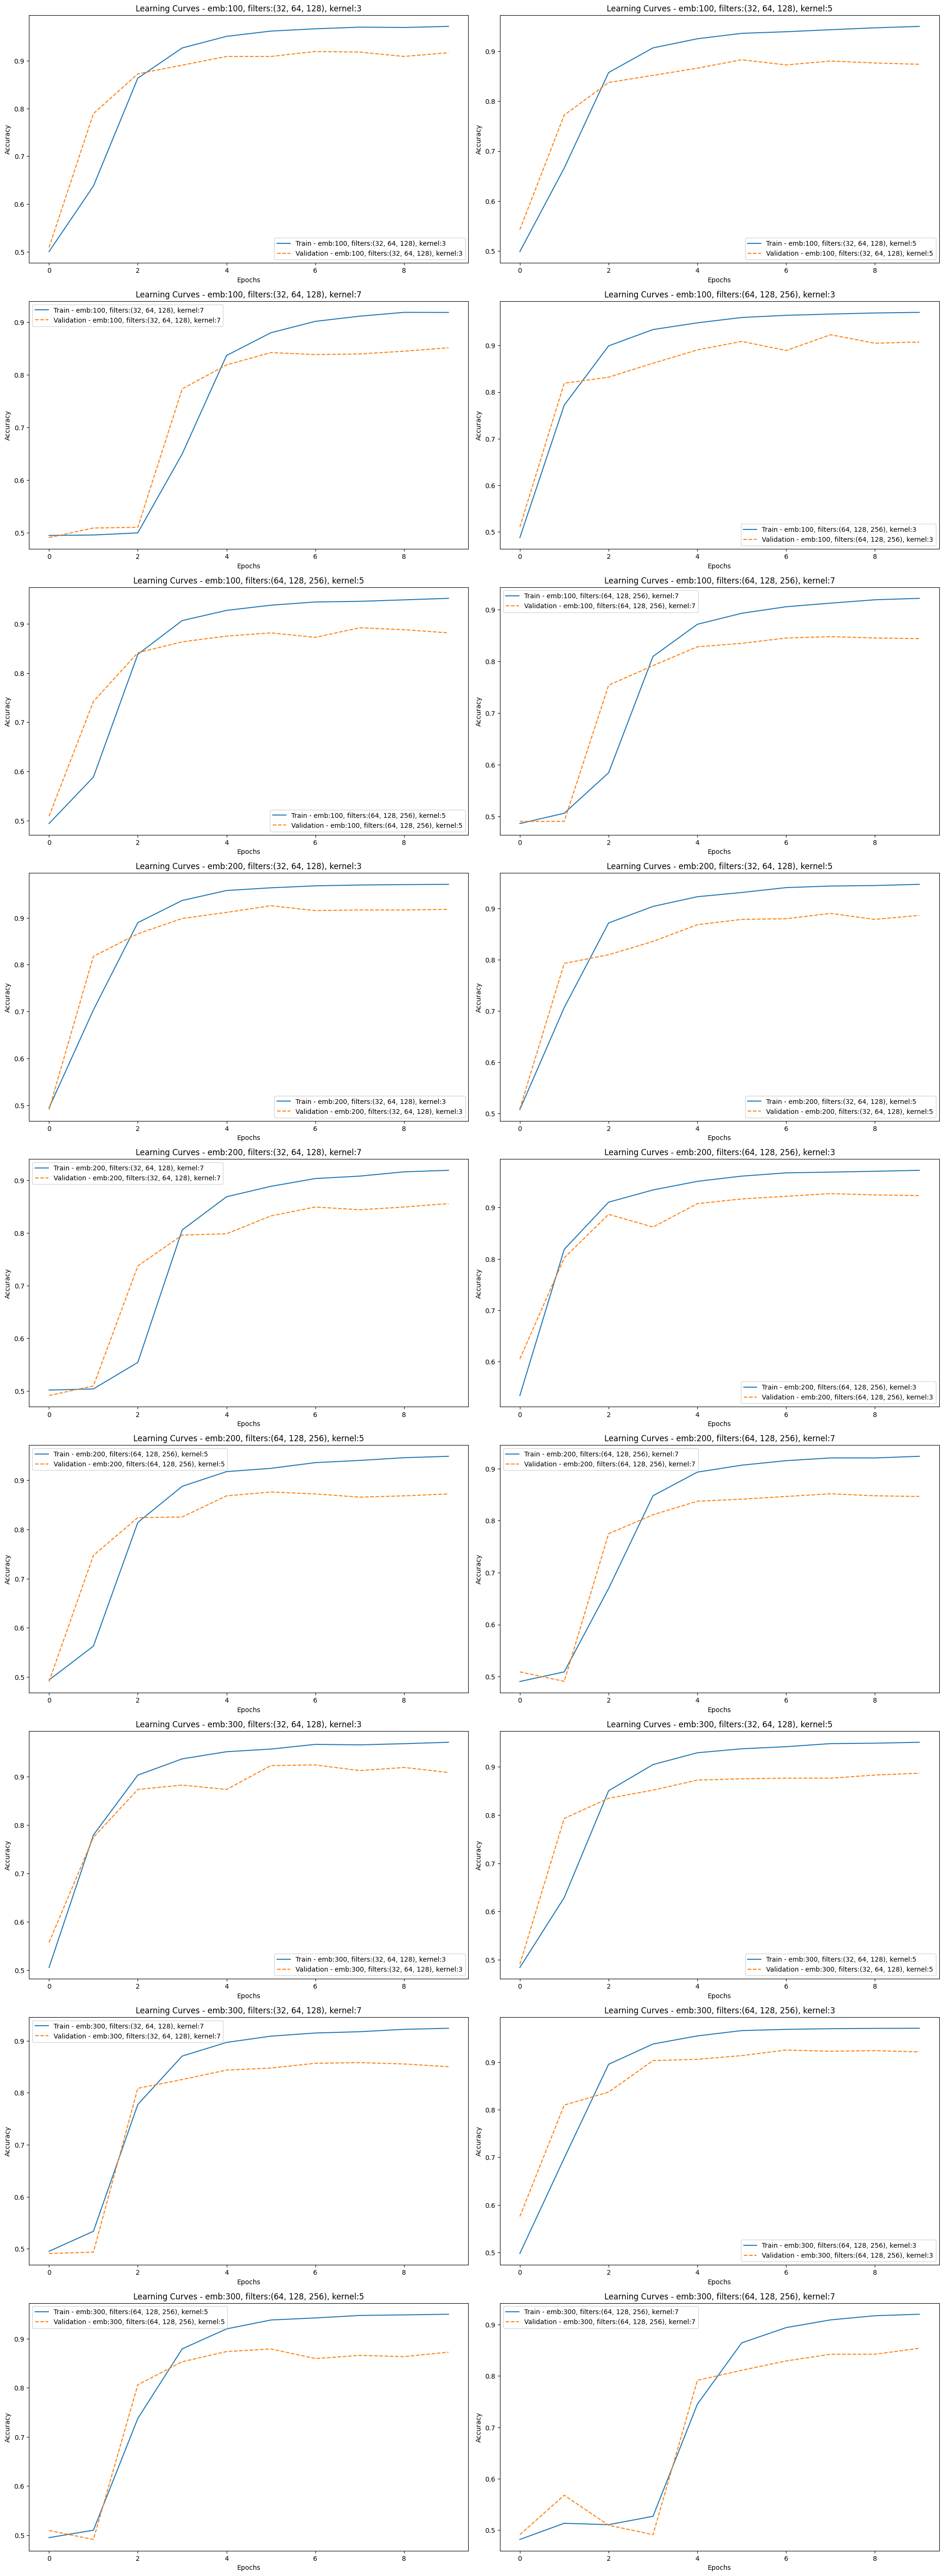

In [ ]:
# Ukuran subplot dan gambar
subplot_width = 10
subplot_height = 6
num_subplots = len(embedding_sizes) * len(filters_combinations) * len(kernel_sizes)
num_cols = 2  # Jumlah kolom dalam satu baris

# Plot learning curves bersampingan
plt.figure(figsize=(num_cols * subplot_width, (num_subplots // num_cols + 1) * subplot_height))

for i, (embedding_size, filters, kernel_size) in enumerate(product(embedding_sizes, filters_combinations, kernel_sizes)):
    # Setiap subplot
    plt.subplot(num_subplots // num_cols + 1, num_cols, i + 1)

    plt.plot(train_accuracy_history[i], label=f'Train - emb:{embedding_size}, filters:{str(filters)}, kernel:{kernel_size}')
    plt.plot(val_accuracy_history[i], label=f'Validation - emb:{embedding_size}, filters:{str(filters)}, kernel:{kernel_size}', linestyle='--')

    plt.title(f'Learning Curves - emb:{embedding_size}, filters:{str(filters)}, kernel:{kernel_size}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

# **Evaluasi Model**

In [ ]:
optimal_embedding_size = best_params['embedding_size']
optimal_filters = best_params['filters']
optimal_kernel_size = best_params['kernel_size']

model_optimal = create_cnn_model(embedding_size=optimal_embedding_size, filters=optimal_filters, kernel_size=optimal_kernel_size)
cnn = model_optimal.fit(data_train, y_train, validation_data=(data_test,y_test), epochs=10, batch_size=100, verbose=1)

Epoch 1/10
70/70 [==============================] - 16s 209ms/step - loss: 1.3648 - accuracy: 0.5052 - val_loss: 1.0133 - val_accuracy: 0.4909
Epoch 2/10
70/70 [==============================] - 12s 165ms/step - loss: 0.7531 - accuracy: 0.7815 - val_loss: 0.7037 - val_accuracy: 0.8346
Epoch 3/10
70/70 [==============================] - 10s 145ms/step - loss: 0.5065 - accuracy: 0.9090 - val_loss: 0.5999 - val_accuracy: 0.8698
Epoch 4/10
70/70 [==============================] - 13s 188ms/step - loss: 0.4007 - accuracy: 0.9386 - val_loss: 0.5612 - val_accuracy: 0.8841
Epoch 5/10
70/70 [==============================] - 16s 236ms/step - loss: 0.3232 - accuracy: 0.9540 - val_loss: 0.4290 - val_accuracy: 0.9154
Epoch 6/10
70/70 [==============================] - 17s 238ms/step - loss: 0.2676 - accuracy: 0.9624 - val_loss: 0.4054 - val_accuracy: 0.9206
Epoch 7/10
70/70 [==============================] - 9s 128ms/step - loss: 0.2330 - accuracy: 0.9656 - val_loss: 0.3966 - val_accuracy: 0.9232


In [ ]:
# Prediksi pada data uji
y_test_pred_optimal = model_optimal.predict(data_test)
y_test_pred_classes_optimal = np.argmax(y_test_pred_optimal, axis=1)

# Mengukur akurasi
accuracy_optimal = accuracy_score(y_test, y_test_pred_classes_optimal)
print(f"Akurasi pada Data Uji: {accuracy_optimal}")
accuracy_optimal_percent = accuracy_optimal * 100
print(f"Akurasi pada Data Uji: {accuracy_optimal_percent:.2f}%")

# Menampilkan laporan klasifikasi
print("Laporan Klasifikasi:")
print(classification_report(y_test, y_test_pred_classes_optimal))

24/24 [==============================] - 0s 10ms/step
Akurasi pada Data Uji: 0.9270833333333334
Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       391
           1       0.92      0.93      0.93       377

    accuracy                           0.93       768
   macro avg       0.93      0.93      0.93       768
weighted avg       0.93      0.93      0.93       768



Text(50.722222222222214, 0.5, 'y_pred')

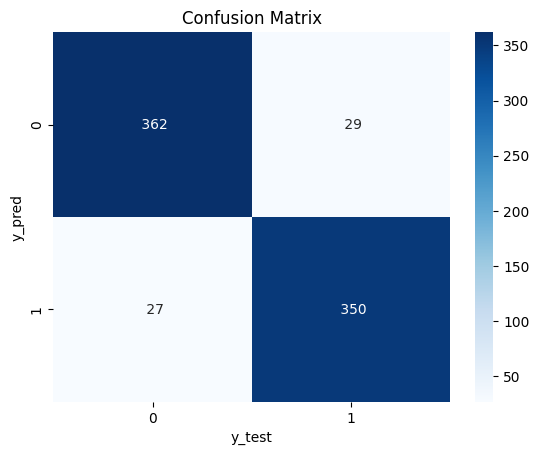

In [ ]:
# Menampilkan confusion matrix
cm_optimal = confusion_matrix(y_test, y_test_pred_classes_optimal)
ax=sns.heatmap(cm_optimal,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

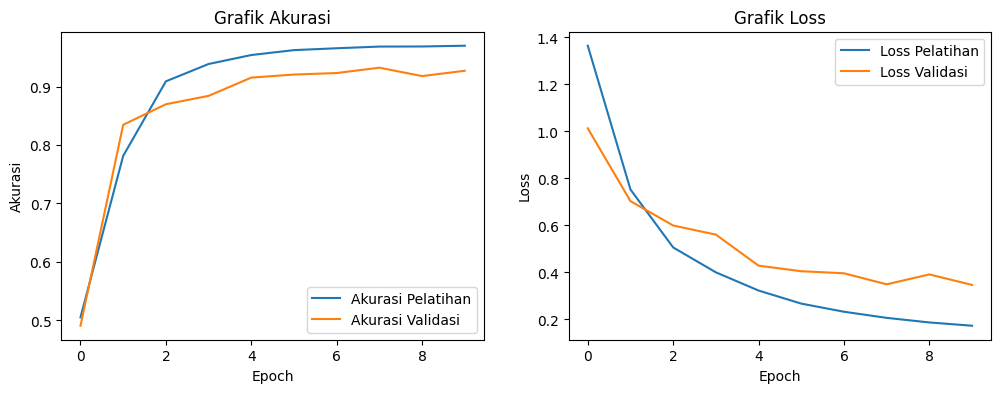

In [ ]:
# Mengumpulkan data evaluasi selama pelatihan
train_loss = cnn.history['loss']
val_loss = cnn.history['val_loss']
train_accuracy = cnn.history['accuracy']
val_accuracy = cnn.history['val_accuracy']

# Plot akurasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Akurasi Pelatihan')
plt.plot(val_accuracy, label='Akurasi Validasi')
plt.legend()
plt.title('Grafik Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Loss Pelatihan')
plt.plot(val_loss, label='Loss Validasi')
plt.legend()
plt.title('Grafik Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()